<div class="alert alert-info">
    
<b>Reference</b>
    
This tutorial is based on materials from the Keras Documentation:
* [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)
    
</div>

## Setup, imports and GPU detection

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
This tutorial should be run with `tensorFlow>=2.6`.
    
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
import json
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to avoid the logging of Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if **GPU** devices are available on the current host.
    
</div>

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]

n_gpus = len(get_available_gpus())
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


### The dataset

Now, we will start by defining our artificial dataset based on a Sinus curve. We will first generate data for a **training set** (used for estimation) and a **testing set** (used to evaluate the final performance). Then the training set will be sub-divided in a new **training set** (used to estimate the neural network weights) and **validation set** (used to estimate the neural network hyperparameters and architecture). The data are generated from the following function:

$$ y = f(x) = 2 \cdot \sin(x) + \epsilon$$

The training data will be generated in a range between $[-30, -20]$ with $\epsilon \sim \mathcal{N}(0,0.25)$ and  in a range between $[20, 30]$ with $\epsilon \sim \mathcal{N}(0,1)$. The code for the training data is then corresponding to:

In [4]:
def load_data_train_test(random_state=42):
    rs = np.random.RandomState(random_state)

    train_size = 400
    f = lambda x: 2*np.sin(x) # a simlpe affine function

    x_1 = rs.uniform(low=-30, high=-20.0, size=train_size//2)
    eps_1 = rs.normal(loc=0.0, scale=0.5, size=train_size//2)
    y_1 = f(x_1) + eps_1

    x_2 = rs.uniform(low=20.0, high=30.0, size=train_size//2)
    eps_2 = rs.normal(loc=0.0, scale=1.0, size=train_size//2)
    y_2 = f(x_2) + eps_2

    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    x_tst = np.linspace(-40.0, 40.0, 200)
    y_tst = f(x_tst)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    x_tst = x_tst.reshape(-1, 1)
    y_tst = y_tst.reshape(-1, 1)

    return (x, y), (x_tst, y_tst)

Then the code to split the training data in a new **training set** and a **validation set** corresponds to:

In [5]:
from sklearn.model_selection import train_test_split

def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    if verbose:
        print(f'train_X shape: {np.shape(train_X)}')
        print(f'train_y shape: {np.shape(train_y)}')
        print(f'valid_X shape: {np.shape(valid_X)}')
        print(f'valid_y shape: {np.shape(valid_y)}')
    return (train_X, train_y), (valid_X, valid_y)


(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx , ty) = load_data_train_test()

train_X shape: (268, 1)
train_y shape: (268, 1)
valid_X shape: (132, 1)
valid_y shape: (132, 1)


<div class="alert alert-info">
    
<b>Note</b>
    
When it is possible to factorize the two previous function into one, DeepHyper interface requires a function which returns `(train_inputs, train_outputs), (valid_inputs, valid_outputs)`.
    
</div>

We can give a visualization of this data:

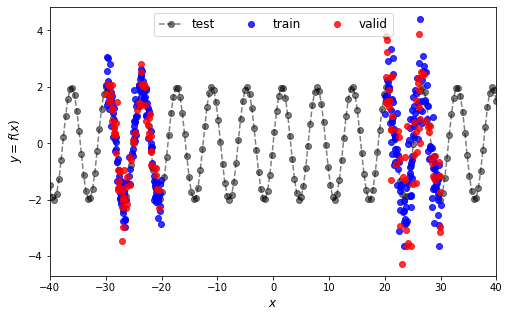

In [6]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx.reshape(-1), ty.reshape(-1), "ko--", label="test", alpha=0.5)
plt.plot(x.reshape(-1), y.reshape(-1), "bo", label="train", alpha=0.8)
plt.plot(vx.reshape(-1), vy.reshape(-1), "ro", label="valid", alpha=0.8)

plt.ylabel("$y = f(x)$", fontsize=12)
plt.xlabel("$x$", fontsize=12)

plt.xlim(-40, 40)
plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()

## Scaling the data

In [7]:
from sklearn.preprocessing import StandardScaler


scaler_x = StandardScaler()
s_x = scaler_x.fit_transform(x)
s_vx = scaler_x.transform(vx)
s_tx = scaler_x.transform(tx)

scaler_y = StandardScaler()
s_y = scaler_y.fit_transform(y)
s_vy = scaler_y.transform(vy)
s_ty = scaler_y.transform(ty)

## The baseline neural network

In [8]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)
output = tf.keras.layers.Dense(1)(out)
model = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, "mse")

history = model.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1)

Epoch 1/200
67/67 [==============================] - 1s 4ms/step - loss: 1.0304 - val_loss: 1.1015
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0169 - val_loss: 1.0920
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0259 - val_loss: 1.0653
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0151 - val_loss: 1.0754
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0027 - val_loss: 1.0805
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0090 - val_loss: 1.0657
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0135 - val_loss: 1.0748
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0005 - val_loss: 1.0752
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0008 - val_loss: 1.0696
Epoch 10/200
67/67 [==============================] - 0s 2ms/step - loss: 0.9991 - val_loss: 1.0715
Epoch 11/

Epoch 83/200
67/67 [==============================] - 0s 966us/step - loss: 0.8461 - val_loss: 0.9426
Epoch 84/200
67/67 [==============================] - 0s 994us/step - loss: 0.8552 - val_loss: 0.9169
Epoch 85/200
67/67 [==============================] - 0s 978us/step - loss: 0.8500 - val_loss: 0.9134
Epoch 86/200
67/67 [==============================] - 0s 981us/step - loss: 0.8331 - val_loss: 0.9210
Epoch 87/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8432 - val_loss: 0.9047
Epoch 88/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8387 - val_loss: 0.9106
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8347 - val_loss: 0.9366
Epoch 90/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8639 - val_loss: 0.9033
Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8455 - val_loss: 0.8979
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 0.8068 - val_loss:

67/67 [==============================] - 0s 945us/step - loss: 0.3736 - val_loss: 0.4579
Epoch 164/200
67/67 [==============================] - 0s 977us/step - loss: 0.3921 - val_loss: 0.4851
Epoch 165/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3843 - val_loss: 0.4463
Epoch 166/200
67/67 [==============================] - 0s 973us/step - loss: 0.3622 - val_loss: 0.4566
Epoch 167/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3595 - val_loss: 0.5277
Epoch 168/200
67/67 [==============================] - 0s 997us/step - loss: 0.3304 - val_loss: 0.4113
Epoch 169/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3291 - val_loss: 0.5025
Epoch 170/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3217 - val_loss: 0.3939
Epoch 171/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3129 - val_loss: 0.4063
Epoch 172/200
67/67 [==============================] - 0s 1ms/step - loss: 0.3216 - val_loss: 0.4

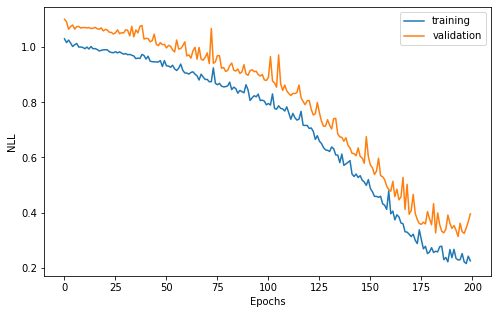

In [9]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("NLL")

plt.legend()

plt.show()

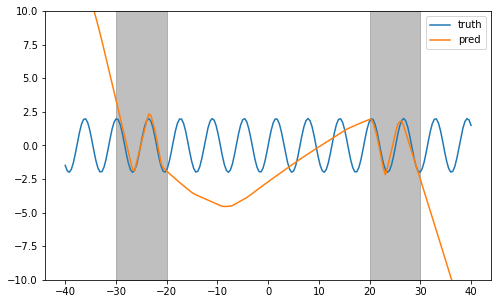

In [10]:
pred_s_ty = model(s_tx)
pred_ty = scaler_y.inverse_transform(pred_s_ty)

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty, label="pred")

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## Define the Neural Architecture Search Space

To do so, we will start by defining the RegressionFactory by implementing the def build(self, ...) method. Then we will wrap this factory into a create_search_space function to follow the DeepHyper problem definition API.

In [11]:
import collections

from deephyper.nas.space import KSearchSpace, SpaceFactory

# Decision variables are represented by nodes in a graph
from deephyper.nas.space.node import ConstantNode, VariableNode

# For Skip/Residual connections
from deephyper.nas.space.op.basic import Zero
from deephyper.nas.space.op.connect import Connect
from deephyper.nas.space.op.merge import AddByProjecting

from deephyper.nas.space.op.op1d import Identity

# The "operation" creates a wrapper around Keras layers
# to avoid allocating memory each time a new layer is defined
# in the search space
from deephyper.nas.space.op import operation

Dense = operation(tf.keras.layers.Dense)

# Possible activation functions
ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]

In [12]:
class RegressionFactory(SpaceFactory):
    
    def build(self, input_shape, output_shape, num_layers=3, **kwargs):

        self.ss = KSearchSpace(input_shape, output_shape)

        out_sub_graph = self.build_sub_graph(self.ss.input_nodes[0], num_layers)

        output = ConstantNode(op=Dense(output_shape[0]))  
        self.ss.connect(out_sub_graph, output)

        return self.ss

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.ss.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self.ss, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self.ss, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.ss.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


def create_search_space(input_shape=(1,), output_shape=(1,), **kwargs):
    return RegressionFactory()(input_shape, output_shape, **kwargs)

Let us visualize a few randomly sampled neural architecture from this search space.

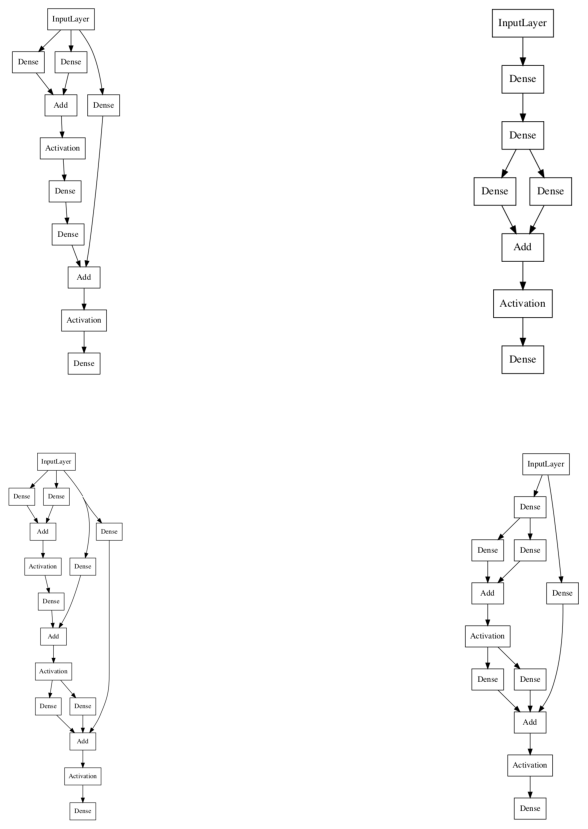

In [13]:
import matplotlib.image as mpimg

shapes = dict(input_shape=(1,), output_shape=(1,))
factory = RegressionFactory()

images = []
plt.figure(figsize=(15,15))
for i in range(4):

    plt.subplot(2,2,i+1)
    factory.plot_model(**shapes, show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Create the Neural Architecture Problem

In [14]:
from deephyper.problem import NaProblem

def stdscaler():
    return StandardScaler()

problem = NaProblem()

problem.load_data(load_data_train_valid)

problem.preprocessing(stdscaler)

problem.search_space(create_search_space, num_layers=3)

problem.hyperparameters(
    batch_size=4,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=200,
    callbacks=dict(
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=30)
    ),
)

problem.loss("mse")

problem.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem.objective("-val_loss")

problem

Problem is:
 * SEED = None *
    - search space   : __main__.create_search_space
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 4
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 200
        * callbacks: {'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 30}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss
    - post-training  : None

<div class="alert alert-info">
    
<b>Tip</b>
    
Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_r2", mode="max", verbose=0, patience=5)
...
```
    
</div>



In [15]:
# We launch the Ray run-time depending on the detected local ressources
# WARNING: in the case of GPUs it is important to follow this scheme
# to avoid multiple processes (Ray workers vs current process) to lock
# the same GPU.
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=1, log_to_driver=False)

2021-09-28 15:51:44,700	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


## Define the evaluator object

In [16]:
from deephyper.evaluator.evaluate import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()]
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

In [17]:
from deephyper.nas.run.alpha import run as run_nas

## Define and run the neural architecture search

In [18]:
results = {}
max_evals = 5

In [19]:
from deephyper.search.nas.random import Random

random_search = Random(problem, get_evaluator(run_nas))

results["random"] = random_search.search(max_evals=max_evals)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7fbdcafb5340>]}
[00001] -- best objective: -0.40301135182380676 -- received objective: -0.40301135182380676
[00002] -- best objective: -0.40301135182380676 -- received objective: -1.0760053396224976
[00003] -- best objective: -0.40301135182380676 -- received objective: -1.0762114524841309
[00004] -- best objective: -0.3523336946964264 -- received objective: -0.3523336946964264
[00005] -- best objective: -0.3523336946964264 -- received objective: -1.109634280204773


In [20]:
from deephyper.search.nas.regevo import RegularizedEvolution

regevo_search = RegularizedEvolution(problem, get_evaluator(run_nas))

results["regevo"] = regevo_search.search(max_evals=max_evals)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7fbdcc3cc9d0>]}
[00001] -- best objective: -1.0675636529922485 -- received objective: -1.0675636529922485
[00002] -- best objective: -0.399662584066391 -- received objective: -0.399662584066391
[00003] -- best objective: -0.399662584066391 -- received objective: -1.0760103464126587
[00004] -- best objective: -0.31800106167793274 -- received objective: -0.31800106167793274
[00005] -- best objective: -0.31800106167793274 -- received objective: -1.017756700515747


Compare the search trajectories for different algorithms.

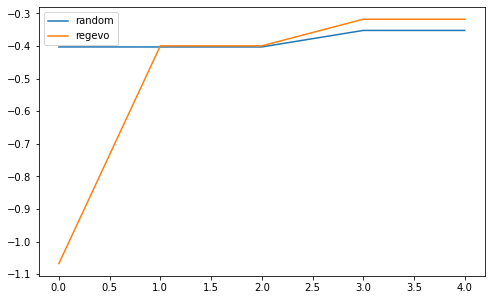

In [21]:
def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)
    
plt.legend()
    
plt.show()

The `arch_seq` corresponds to an embedding for each architecture.

In [22]:
results["random"]

,arch_seq,id,objective,elapsed_sec,duration
0,"[88, 1, 166, 1, 1, 80, 0, 1, 0]",1,-0.403011,18.010510,17.989639
1,"[79, 0, 77, 0, 0, 167, 0, 0, 0]",2,-1.076005,20.284842,2.273494
2,"[154, 0, 77, 0, 0, 130, 0, 0, 0]",3,-1.076211,22.625365,2.339823
3,"[131, 1, 60, 1, 0, 54, 1, 0, 0]",4,-0.352334,33.876887,11.250737
4,"[29, 1, 94, 0, 1, 41, 0, 1, 1]",5,-1.109634,38.301940,4.424400


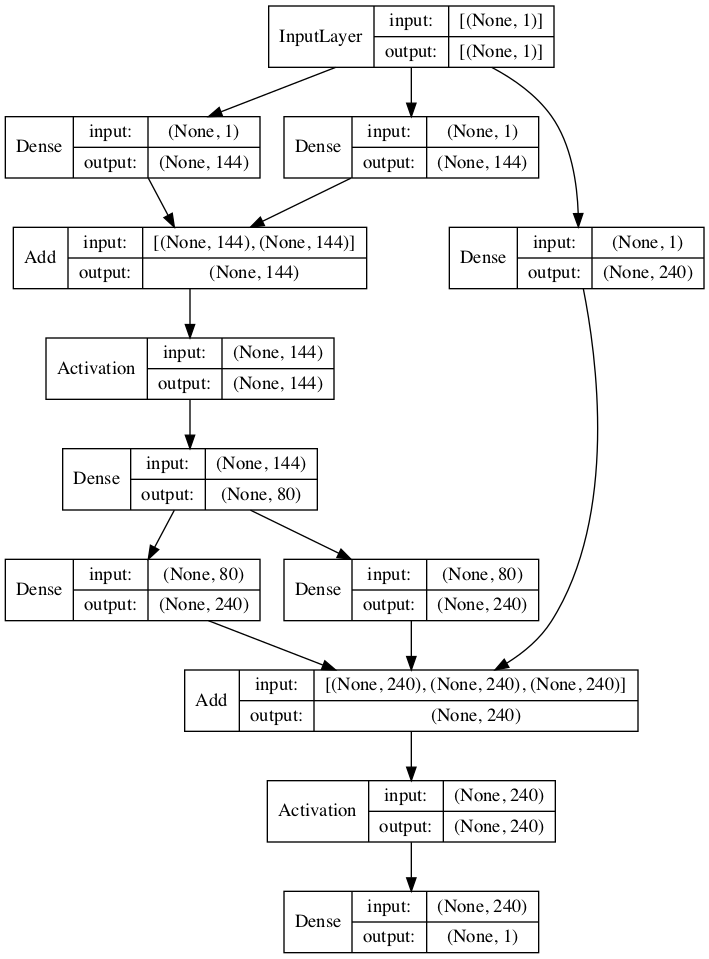

In [23]:

i_max = results["random"].objective.argmax()
best_score = results["random"].iloc[i_max].objective
best_arch_seq = json.loads(results["random"].iloc[i_max].arch_seq)

factory.plot_model(arch_seq=best_arch_seq, **shapes, show_shapes=True, show_layer_names=False)

## Model with Uncertainty Quantification

In [24]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [25]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability."""
    return -rv_y.log_prob(y)

In [26]:
input_ = tf.keras.layers.Input(shape=(1,))
out = tf.keras.layers.Dense(200, activation="relu")(input_)
out = tf.keras.layers.Dense(200, activation="relu")(out)
out = tf.keras.layers.Dense(2)(out) # 1 unit for the mean, 1 unit for the scale
output = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]),
            )
        )(out)
model_uq = tf.keras.Model(input_, output)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_uq.compile(optimizer, loss=nll)

history = model_uq.fit(s_x, s_y, epochs=200, batch_size=4, validation_data=(s_vx, s_vy), verbose=1)

Epoch 1/200
67/67 [==============================] - 1s 3ms/step - loss: 1.6083 - val_loss: 1.6935
Epoch 2/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5771 - val_loss: 1.6425
Epoch 3/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5414 - val_loss: 1.5899
Epoch 4/200
67/67 [==============================] - 0s 1ms/step - loss: 1.5258 - val_loss: 1.5161
Epoch 5/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4612 - val_loss: 1.5014
Epoch 6/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4390 - val_loss: 1.4820
Epoch 7/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4369 - val_loss: 1.4534
Epoch 8/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4282 - val_loss: 1.4510
Epoch 9/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4272 - val_loss: 1.4677
Epoch 10/200
67/67 [==============================] - 0s 1ms/step - loss: 1.4321 - val_loss: 1.4565
Epoch 11/

67/67 [==============================] - 0s 1ms/step - loss: 1.3721 - val_loss: 1.4269
Epoch 84/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3799 - val_loss: 1.4240
Epoch 85/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3744 - val_loss: 1.4227
Epoch 86/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3598 - val_loss: 1.4474
Epoch 87/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3785 - val_loss: 1.4254
Epoch 88/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3653 - val_loss: 1.4277
Epoch 89/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3635 - val_loss: 1.4176
Epoch 90/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3580 - val_loss: 1.4187
Epoch 91/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3606 - val_loss: 1.4360
Epoch 92/200
67/67 [==============================] - 0s 1ms/step - loss: 1.3623 - val_loss: 1.4340
Epoch 93/200


67/67 [==============================] - 0s 1ms/step - loss: 1.1354 - val_loss: 1.1761
Epoch 165/200
67/67 [==============================] - 0s 1ms/step - loss: 1.2328 - val_loss: 1.1932
Epoch 166/200
67/67 [==============================] - 0s 1ms/step - loss: 1.1269 - val_loss: 1.1787
Epoch 167/200
67/67 [==============================] - 0s 1ms/step - loss: 1.1382 - val_loss: 1.1813
Epoch 168/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0818 - val_loss: 1.2019
Epoch 169/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0740 - val_loss: 1.1628
Epoch 170/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0745 - val_loss: 1.1535
Epoch 171/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0789 - val_loss: 1.1152
Epoch 172/200
67/67 [==============================] - 0s 1ms/step - loss: 1.1413 - val_loss: 1.1834
Epoch 173/200
67/67 [==============================] - 0s 1ms/step - loss: 1.0791 - val_loss: 1.1081
Epoc

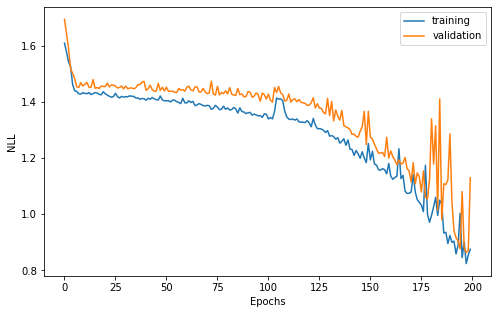

In [27]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("NLL")

plt.legend()

plt.show()

<class 'tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible'>


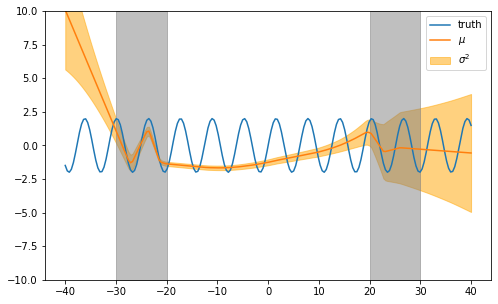

In [28]:
pred_s_ty = model_uq(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_var = np.square(pred_s_ty.scale.numpy()) * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_var).reshape(-1), 
    (pred_ty_mean + pred_ty_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$\sigma^2$"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## Ensemble of neural networks with random initialization

In [29]:
def generate_model(model_id):
    
    # Model
    input_ = tf.keras.layers.Input(shape=(1,))
    out = tf.keras.layers.Dense(200, activation="relu")(input_)
    out = tf.keras.layers.Dense(200, activation="relu")(out)
    out = tf.keras.layers.Dense(2)(out) # 1 unit for the mean, 1 unit for the scale
    output = tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]),
                )
            )(out)
    model_uq = tf.keras.Model(input_, output)
    
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models_random_init", f"{model_id}.h5"), 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=False, 
        mode='min', 
        save_freq='epoch'
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model_uq.compile(optimizer, loss=nll)

    history = model_uq.fit(s_x, s_y, 
                           epochs=200, 
                           batch_size=4, 
                           validation_data=(s_vx, s_vy), 
                           verbose=0,
                           callbacks=[model_checkpoint_callback]
                          )

In [75]:
if os.path.exists("models_random_init"):
    shutil.rmtree("models_random_init")
pathlib.Path("models_random_init").mkdir(parents=False, exist_ok=False)

for model_id in tqdm(range(10)):
    generate_model(model_id)

100%|██████████| 10/10 [02:30<00:00, 15.01s/it]


In [40]:
from deephyper.ensemble import UQBaggingEnsembleRegressor

ensemble = UQBaggingEnsembleRegressor(
    model_dir="models_random_init",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="topk",
)

In [41]:
ensemble.fit(s_vx, s_vy)

print(f"Selected members are: ", ensemble.members_files)

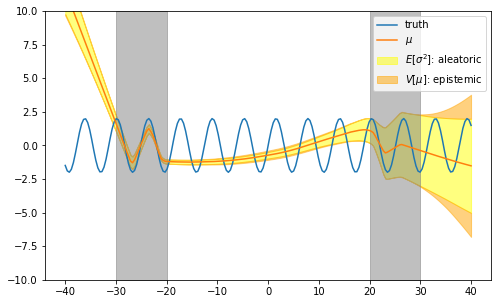

In [43]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
#     label="$V[\mu]$: epistemic"
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()

## AutoDEUQ: Automated Deep Ensemble with Uncertainty quantification

In [ ]:
DistributionLambda = operation(tfp.layers.DistributionLambda)

In [44]:
class RegressionUQFactory(SpaceFactory):
    
    def build(self, input_shape, output_shape, num_layers=3, **kwargs):

        self.ss = KSearchSpace(input_shape, output_shape)

        out_sub_graph = self.build_sub_graph(self.ss.input_nodes[0], num_layers)
        
        output_dim = output_shape[0]
        output_dense = ConstantNode(op=Dense(output_dim*2))  
        self.ss.connect(out_sub_graph, output_dense)
        
        
        output_dist = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., output_dim:]),
                )
            )
        )
        self.ss.connect(output_dense, output_dist)

        return self.ss

    def build_sub_graph(self, input_node, num_layers=3):
        

        # Look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([input_node], maxlen=3)
        
        prev_node = input_node
        
        for _ in range(num_layers):
            
            # Create a variable node to list possible "Dense" layers
            dense = VariableNode()
            
            # Add the possible operations to the dense node
            self.add_dense_to_(dense)
            
            # Connect the previous node to the dense node
            self.ss.connect(prev_node, dense)

            # Create a constant node to merge all input connections
            merge = ConstantNode()
            merge.set_op(
                AddByProjecting(self.ss, [dense], activation="relu")
            )

            for node in anchor_points:
                
                # Create a variable node for each possible connection
                skipco = VariableNode()
                
                skipco.add_op(Zero()) # corresponds to no connection
                skipco.add_op(Connect(self.ss, node)) # corresponds to (node => skipco)
                
                # Connect the (skipco => merge)
                self.ss.connect(skipco, merge)

 
            # ! for next iter
            prev_node = merge
            anchor_points.append(prev_node)

        return prev_node

    def add_dense_to_(self, node):
        
        # We add the "Identity" operation to allow the choice "doing nothing"
        node.add_op(Identity())
        
        step = 16
        for units in range(step, step * 16 + 1, step):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))


def create_search_space_uq(input_shape=(1,), output_shape=(1,), **kwargs):
    return RegressionUQFactory()(input_shape, output_shape, **kwargs)

In [55]:
problem_uq = NaProblem()

problem_uq.load_data(load_data_train_valid)

problem_uq.preprocessing(stdscaler)

problem_uq.search_space(create_search_space_uq, num_layers=3)

problem_uq.hyperparameters(
    batch_size=problem_uq.add_hyperparameter((1, 20), "batch_size"),
    learning_rate=problem_uq.add_hyperparameter(
        (1e-4, 0.1, "log-uniform"),
        "learning_rate",
    ),
    optimizer=problem_uq.add_hyperparameter(
        ["sgd", "rmsprop", "adagrad", "adam", "adadelta", "adamax", "nadam"],
        "optimizer",
    ),
    patience_ReduceLROnPlateau=problem_uq.add_hyperparameter(
        (3, 30), "patience_ReduceLROnPlateau"
    ),
    patience_EarlyStopping=problem_uq.add_hyperparameter(
        (3, 30), "patience_EarlyStopping"
    ),
    num_epochs=100,
    callbacks=dict(
        ReduceLROnPlateau=dict(monitor="val_loss", mode="min", verbose=0, patience=5),
        EarlyStopping=dict(
            monitor="val_loss", mode="min", verbose=0, patience=10
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        ),
    ),
)

problem_uq.loss(nll)

problem_uq.metrics([])

# The objective is maximized so we take the negative of the validation loss
# where the loss is minimized
problem_uq.objective("-val_loss")

problem_uq

Problem is:
 * SEED = None *
    - search space   : __main__.create_search_space_uq
    - data loading   : __main__.load_data_train_valid
    - preprocessing  : __main__.stdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [1, 20], Default: 10
        * learning_rate: learning_rate, Type: UniformFloat, Range: [0.0001, 0.1], Default: 0.0031622777, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {sgd, rmsprop, adagrad, adam, adadelta, adamax, nadam}, Default: sgd
        * patience_ReduceLROnPlateau: patience_ReduceLROnPlateau, Type: UniformInteger, Range: [3, 30], Default: 16
        * patience_EarlyStopping: patience_EarlyStopping, Type: UniformInteger, Range: [3, 30], Default: 16
        * num_epochs: 100
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 5}, 'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 

In [56]:
results_uq = {}

In [70]:
from deephyper.search.nas.agebo import AgEBO


if os.path.exists("save"):
    shutil.rmtree("save")

agebo_search = AgEBO(problem_uq, get_evaluator(run_nas))

results_uq["agebo"] = agebo_search.search(max_evals=max_evals)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7fbdcd985790>]}
[00001] -- best objective: -1.4542121887207031 -- received objective: -1.4542121887207031
[00002] -- best objective: -1.4542121887207031 -- received objective: -1.4685238599777222
[00003] -- best objective: -1.4542121887207031 -- received objective: -1.5967555046081543
[00004] -- best objective: -1.4542121887207031 -- received objective: -1.4569947719573975
[00005] -- best objective: -1.4542121887207031 -- received objective: -1.7006527185440063


In [73]:
results_uq["agebo"]

,arch_seq,batch_size,learning_rate,optimizer,patience_EarlyStopping,patience_ReduceLROnPlateau,id,objective,elapsed_sec,duration
0,"[151, 1, 111, 1, 0, 151, 0, 1, 1]",20,0.004855,adamax,25,14,1,-1.454212,3.030506,2.909052
1,"[158, 1, 27, 1, 1, 145, 1, 1, 0]",19,0.009209,adam,3,21,2,-1.468524,4.491147,1.313796
2,"[87, 0, 169, 0, 1, 102, 1, 0, 1]",14,0.003828,sgd,21,6,3,-1.596756,6.638214,1.959082
3,"[150, 0, 156, 0, 0, 81, 0, 0, 1]",20,0.009358,adam,14,15,4,-1.456995,8.937215,2.141961
4,"[6, 0, 174, 1, 1, 20, 1, 0, 0]",20,0.000798,adadelta,15,11,5,-1.700653,14.970218,5.876341


In [71]:
ensemble = UQBaggingEnsembleRegressor(
    model_dir="save/model",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="caruana",
)

ensemble.fit(s_vx, s_vy)

print(f"Selected members are: ", ensemble.members_files)

Selected members are:  ['c98672ba-206a-11ec-b344-acde48001122_28-Sep-2021_16-45-56.h5']


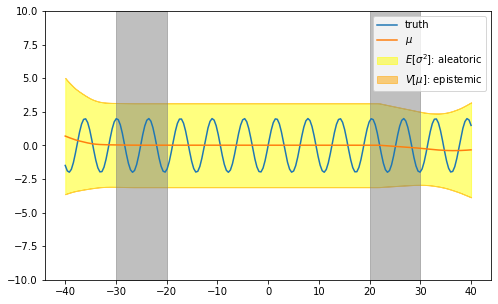

In [72]:
pred_s_ty, pred_s_ty_aleatoric_var, pred_s_ty_epistemic_var = ensemble.predict_var_decomposition(s_tx)

pred_ty_mean = pred_s_ty.loc.numpy() + scaler_y.mean_
pred_ty_aleatoric_var = pred_s_ty_aleatoric_var * scaler_y.var_
pred_ty_epistemic_var = pred_s_ty_epistemic_var * scaler_y.var_

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(tx, ty, label="truth")
plt.plot(tx, pred_ty_mean, label="$\mu$")
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    color="yellow", 
    alpha=0.5,
    label="$E[\sigma^2]$: aleatoric"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean - pred_ty_aleatoric_var - pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
    label="$V[\mu]$: epistemic"
)
plt.fill_between(
    tx.reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var).reshape(-1), 
    (pred_ty_mean + pred_ty_aleatoric_var + pred_s_ty_epistemic_var).reshape(-1), 
    color="orange", 
    alpha=0.5,
)

y_lim = 10
plt.fill_between([-30, -20], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)
plt.fill_between([20, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="grey", alpha=0.5)

plt.legend()
plt.ylim(-y_lim, y_lim)

plt.show()